<a href="https://colab.research.google.com/github/nimarta-devi/card_scanner/blob/main/business_card_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ONLY run this cell once, then the kernel will automatically restart runtime. You can run the 2nd cell without run this cell again 

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install --ignore-installed Pillow==9.0.0
!pip install fpdf

from IPython.display import clear_output

clear_output()
exit()

### Program section

In [ ]:
from fpdf import FPDF
from IPython.display import clear_output
import os
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab import files 
import ipywidgets as widgets
import numpy as np
import pytesseract
import shutil
import random
try:
    from PIL import Image
except ImportError:
    import Image

clear_output()

Saving Ingoude Company (2).png to Ingoude Company (2).png


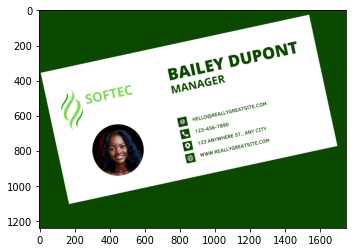

In [ ]:
# Upload Image file
try:
  os.remove(newname)
except:
  pass
uploaded = files.upload()
for fn in uploaded.keys():
  oldname = fn

filetype = oldname.split('.')[-1]
newname = "card_img." + filetype
os.rename(oldname, newname)
path = "/content/" + newname

# initialize Variable
widthImg = 1920
heightImg = 1080
lower = 100
upper = 150
kernel = np.ones((5,5)) 
NAME = ""
ROLE = ""
COMPANY = ""
EMAIL = ""
PHONE = ""
WEBSITE = ""
ADDRESS = ""

# Read uploaded image
img_card = cv.imread(path)
img_card = cv.cvtColor(img_card, cv.COLOR_BGR2RGB)


# 1 convert to gray image
imgGray = cv.cvtColor(img_card, cv.COLOR_RGB2GRAY)

# 2 apply gaussian blur
imgBlur = cv.GaussianBlur(imgGray, (5, 5), 1)

plt.imshow(img_card)

IntSlider(value=204, description='lower threshold:', max=255)

IntSlider(value=255, description='upper threshold:', max=255)

Button(button_style='success', description='Canny Edge Detect', style=ButtonStyle(), tooltip='Click me')

Lower thresh = 204
Upper thresh = 255


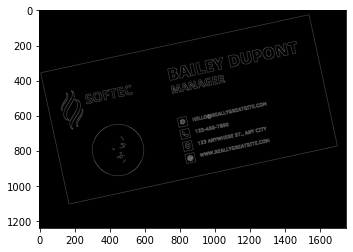

In [ ]:
def threshBar():

  threshBar.btn = widgets.Button(
    description = 'Canny Edge Detect',
    disabled = False,
    button_style = 'success',
    tooltip = 'Click me',
  )

  threshBar.lowerThresh = widgets.IntSlider(
                          value=100,
                          min=0,
                          max=255,
                          step=1,
                          description='lower threshold:',
                          disabled=False,
                          continuous_update=True,
                          orientation='horizontal',
                          readout=True,
                          readout_format='d'
                      )
  threshBar.upperThresh = widgets.IntSlider(
                          value=150,
                          min=0,
                          max=255,
                          step=1,
                          description='upper threshold:',
                          disabled=False,
                          continuous_update=True,
                          orientation='horizontal',
                          readout=True,
                          readout_format='d'
                          )

  def btn_clicked(b):
    global lower
    global upper
    lower = threshBar.lowerThresh.value
    upper = threshBar.upperThresh.value
    clear_output()
    display(threshBar.lowerThresh)
    display(threshBar.upperThresh)
    display(threshBar.btn)
    print("Lower thresh = {}".format(lower))
    print("Upper thresh = {}".format(upper))
    imgThreshold = cv.Canny(imgBlur, lower, upper)
    plt.imshow(imgThreshold, cmap = 'gray', vmin=0, vmax=255)

  threshBar.btn.on_click(btn_clicked)
  display(threshBar.lowerThresh)
  display(threshBar.upperThresh)
  display(threshBar.btn)
  imgThreshold = cv.Canny(imgBlur, lower, upper)
  plt.imshow(imgThreshold, cmap = 'gray', vmin=0, vmax=255)

# // Adjust lower and upper threshold value from int sliders //
threshBar()

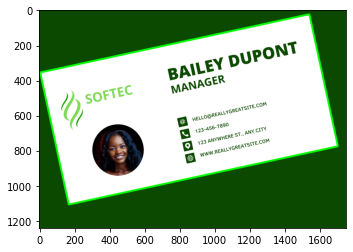

In [ ]:
# 3 Apply Canny Edge detection
imgThreshold = cv.Canny(imgBlur, lower, upper)

# 4 Apply Dilation
imgDial = cv.dilate(imgThreshold, kernel, iterations=2)

# 5 Apply Erosion
imgErode = cv.erode(imgDial, kernel, iterations=1)

# 6 Find Contour
contours, hierarchy = cv.findContours(imgErode, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# // Draw all Contour //
imgContours = img_card.copy()
cv.drawContours(imgContours, contours, -1, (0, 255, 0), 10)
plt.imshow(imgContours)

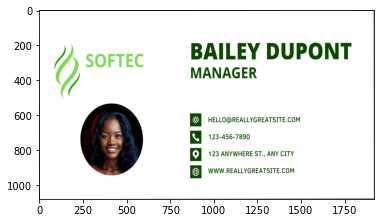

In [ ]:
# 7 Find biggest Contour
biggest = np.array([])
max_area = 0
for i in contours:
    area = cv.contourArea(i)
    if area > 5000:
        peri = cv.arcLength(i, True)
        approx = cv.approxPolyDP(i, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
            biggest = approx
            max_area = area

# 8 Reorder 4 points of contour's corner
myPoints = biggest      
myPoints = myPoints.reshape((4, 2))
myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
add = myPoints.sum(1)

myPointsNew[0] = myPoints[np.argmin(add)]
myPointsNew[3] =myPoints[np.argmax(add)]
diff = np.diff(myPoints, axis=1)
myPointsNew[1] =myPoints[np.argmin(diff)]
myPointsNew[2] = myPoints[np.argmax(diff)]
biggest_new = myPointsNew

# 9 Perform Perspective crop
pts1 = np.float32(biggest_new)
pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg], [widthImg, heightImg]])
matrix = cv.getPerspectiveTransform(pts1, pts2)
imgWarp = cv.warpPerspective(img_card, matrix, (widthImg, heightImg))
imgWarp = cv.resize(imgWarp, (widthImg, heightImg),interpolation = cv.INTER_AREA)
img_temp = imgWarp.copy()
img_temp = cv.cvtColor(img_temp, cv.COLOR_RGB2BGR)
cv.imwrite('colored_img.jpg', img_temp)

plt.imshow(imgWarp)

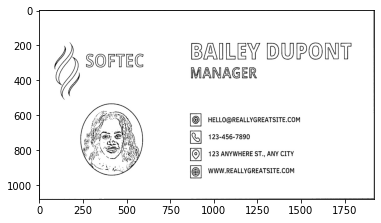

In [ ]:
# // Convert cropped image to gray scale //
imgWarp = cv.cvtColor(imgWarp,cv.COLOR_RGB2GRAY)

# 10 Apply adaptive threshold
imgAdaptiveThre = cv.adaptiveThreshold(imgWarp, 255, 1, 1, 7, 2)
imgAdaptiveThre = cv.bitwise_not(imgAdaptiveThre)

# 11 Apply median blur
imgMed = cv.medianBlur(imgAdaptiveThre, 3)

cv.imwrite('scanned_card.jpg', imgMed) 
img_scan = cv.imread('scanned_card.jpg')
plt.imshow(img_scan)

In [ ]:
# Extract text from card using google tesseract Optical character recognition
extractedInformation = pytesseract.image_to_string(Image.open('scanned_card.jpg'))

# Get rid of some OCR error text extraction
splt = extractedInformation.split('\n')
for i in range(len(splt)-1, -1, -1):
  if len(splt[i]) < 4:
    del splt[i]
  else:
    space = True
    for j in splt[i]:
      if j != ' ' and j != '\t':
        space = False
    if space:
      del splt[i]
splt.append('None')

In [ ]:
def infoSelect():
  infoSelect.name = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Name :',
    disabled = False,
    layout={'width': 'max-content'}
  )
  
  infoSelect.jobRole = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Role :',
    disabled = False,
    layout={'width': 'max-content'}
  )

  infoSelect.email = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Email :',
    disabled = False,
    layout={'width': 'max-content'}
  )

  infoSelect.phone = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Phone No. :',
    disabled = False,
    layout={'width': 'max-content'}
  )

  infoSelect.address = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Role :',
    disabled = False,
    layout={'width': 'max-content'}
  )

  infoSelect.company = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Company :',
    disabled = False,
    layout={'width': 'max-content'}
  )

  infoSelect.website = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Website :',
    disabled = False,
    layout={'width': 'max-content'}
  )
  infoSelect.address = widgets.Dropdown(
    options = splt,
    value = 'None',
    description = 'Address :',
    disabled = False,
    layout={'width': 'max-content'}
  )

  infoSelect.btn1 = widgets.Button(
    description = 'Save',
    disabled = False,
    button_style = 'success',
    tooltip = 'Click me',
  )

  infoSelect.btn2 = widgets.Button(
    description = 'Reset',
    disabled = False,
    button_style = 'warning',
    tooltip = 'Click me',
  )

  def btn1_clicked(b):
    global NAME
    global ROLE
    global COMPANY
    global EMAIL
    global PHONE
    global WEBSITE
    global ADDRESS
    NAME = infoSelect.name.value
    ROLE = infoSelect.jobRole.value
    COMPANY =infoSelect.company.value
    EMAIL = infoSelect.email.value
    PHONE = infoSelect.phone.value
    WEBSITE = infoSelect.website.value
    ADDRESS = infoSelect.address.value
    writeTXT()
    print("successfully save infomation")

  def btn2_clicked(b):
    infoSelect.name.value = None
    infoSelect.jobRole.value = None
    infoSelect.company.value = None
    infoSelect.email.value = None
    infoSelect.phone.value = None
    infoSelect.website.value = None
    infoSelect.address.value = None

  def writeTXT():
    try:
      os.remove('data.txt')
    except:
      pass
    f = open("data.txt","w+")
    f.write('Name - Surname: ' + NAME + '\n')
    f.write('Role: '           + ROLE + '\n')
    f.write('Company: '        + COMPANY + '\n')
    f.write('Email: '          + EMAIL + '\n')
    f.write('Phone: '          + PHONE + '\n')
    f.write('Website: '        + WEBSITE + '\n')
    f.write('Address: '        + ADDRESS + '\n')
    f.close()


  infoSelect.btn1.on_click(btn1_clicked)
  infoSelect.btn2.on_click(btn2_clicked)

  display(infoSelect.name)
  display(infoSelect.jobRole)
  display(infoSelect.company)
  display(infoSelect.email)
  display(infoSelect.phone)
  display(infoSelect.website)
  display(infoSelect.address)
  display(infoSelect.btn1, infoSelect.btn2)

# Select each dropdown to match the infomation
infoSelect()

Dropdown(description='Name :', index=8, layout=Layout(width='max-content'), options=('v SOFTEC', 'BAILEY DUPON…

Dropdown(description='Role :', index=8, layout=Layout(width='max-content'), options=('v SOFTEC', 'BAILEY DUPON…

Dropdown(description='Company :', index=8, layout=Layout(width='max-content'), options=('v SOFTEC', 'BAILEY DU…

Dropdown(description='Email :', index=8, layout=Layout(width='max-content'), options=('v SOFTEC', 'BAILEY DUPO…

Dropdown(description='Phone No. :', index=8, layout=Layout(width='max-content'), options=('v SOFTEC', 'BAILEY …

Dropdown(description='Website :', index=8, layout=Layout(width='max-content'), options=('v SOFTEC', 'BAILEY DU…

Dropdown(description='Address :', index=8, layout=Layout(width='max-content'), options=('v SOFTEC', 'BAILEY DU…

Button(button_style='success', description='Save', style=ButtonStyle(), tooltip='Click me')

Button(button_style='warning', description='Reset', style=ButtonStyle(), tooltip='Click me')

successfully save infomation


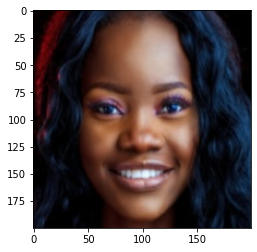

In [ ]:
# Extract Face from Card using Haarcascade Classifier
image = cv.imread('colored_img.jpg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
face_img = None
faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

for (x, y, w, h) in faces:
    roi_color = image[y - 35 :y + h + 35 , x - 35 :x + w + 35]
    roi_color = cv.resize(roi_color, (200, 200), interpolation = cv.INTER_AREA)
    try:
      os.remove('face_img.jpg')
    except:
      pass
    cv.imwrite('face_img.jpg', roi_color)

face_img = cv.imread('face_img.jpg')
face_img = cv.cvtColor(face_img, cv.COLOR_BGR2RGB)
plt.imshow(face_img)

In [ ]:
class PDF(FPDF):
    def lines(self):
        self.set_line_width(0.0)
        self.line(5.0, 5.0, 205.0, 5.0)
        self.line(5.0, 292.0, 205.0, 292.0)
        self.line(5.0, 5.0, 5.0, 292.0)
        self.line(205.0, 5.0, 205.0, 292.0)
        
    def imagex(self):
        self.set_xy(70.0,30.0)
        self.image('face_img.jpg',  link='', type='')

    def titles(self):
        self.set_xy(0.0,0.0)
        self.set_font('Arial', 'B', 16)
        self.set_text_color(0, 0, 0)
        self.cell(w=210.0, h=40.0, align='C', txt="Card infomation", border=0)

    def texts(self,name):
        with open(name,'rb') as xy:
            txt = xy.read().decode('utf-8')
        self.set_xy(30.0, 110.0)    
        self.set_text_color(0, 0, 0)
        self.set_font('Arial', '', 12)
        self.multi_cell(0,10,txt)


# Write face image and infomation in PDF and download
try:
  os.remove('Card_infomation.pdf')
except:
  pass
pdf = PDF(orientation='P', unit='mm', format='A4')
pdf.add_page()
pdf.lines()
pdf.imagex()
pdf.titles()
pdf.texts('data.txt')
pdf.output('Card_infomation.pdf','F')
files.download('Card_infomation.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>